# Physics-Based Scene Simulation: Visualization of Reactive Balanced Body with Fluid Collisions

This notebook visualizes the dynamic response of a simplified human body model using a physics-based inverted pendulum system with fluid-body interactions. It simulates:
- **Reactive stepping** to maintain balance after perturbations.
- **Articulated arms** and **balanced torso** with PD control.
- **Fluid particle collisions** against the full-body figure.

Simulation data is imported from `main_simulation.py`, and animated using `matplotlib`.

## Table of Contents
1. Approach
2. Equations of Motion
3. Notebook Code for Visualization

## 1. Approach <a name="approach"></a>

This simulation uses a **PD controller** to dynamically maintain balance. When an external impulse pushes the center of mass (COM) beyond a threshold, the system performs a **reactive step** to recover. The arms are modeled as two-link pendulums with their own joint-level PD control to stabilize their posture. Fluid particles (rain) interact with the body through realistic 2D collisions.


## 2. Equations of Motion

The dynamics of the reactive stepping model are described by the following equations:

$$
\tau = -K_p \theta - K_d \omega
$$

$$
\frac{d\omega}{dt} = \frac{\tau - c\, \omega}{m l^2}
$$

$$
\frac{d\theta}{dt} = \omega
$$

**Where:**

- $\tau$ is the control torque applied.
- $\theta$ is the angle of the body relative to vertical.
- $\omega$ is the angular velocity ($\frac{d\theta}{dt}$).
- $K_p, K_d$ are the proportional and derivative control gains.
- $c$ is the explicit damping coefficient (set as 0.2).
- $m$ is the mass.
- $l$ is the length of the pendulum (leg).

---

### Arm Target Oscillation (Right Elbow):

$$
\theta_{\text{target}} = \frac{\pi}{6} + 0.3 \sin(2\pi \cdot 1.5 \cdot t)
$$

This equation creates a smooth oscillation in the right elbow angle to simulate movement.

---

### Fluid Reflection Velocity Update:

For particles colliding with a segment, the velocity is reflected using:

$$
\vec{v}_{\text{reflected}} = \vec{v} - (1 + e)(\vec{v} \cdot \hat{n})\hat{n}
$$

**Where:**

- $\vec{v}$ is the incoming particle velocity.
- $e$ is the elasticity coefficient (between 0 and 1).
- $\hat{n}$ is the unit normal vector of the segment.


## 3. Notebook code for visualization

In [1]:
# Needed to see animation if using jupyter notebook
%matplotlib notebook


<IPython.core.display.Javascript object>


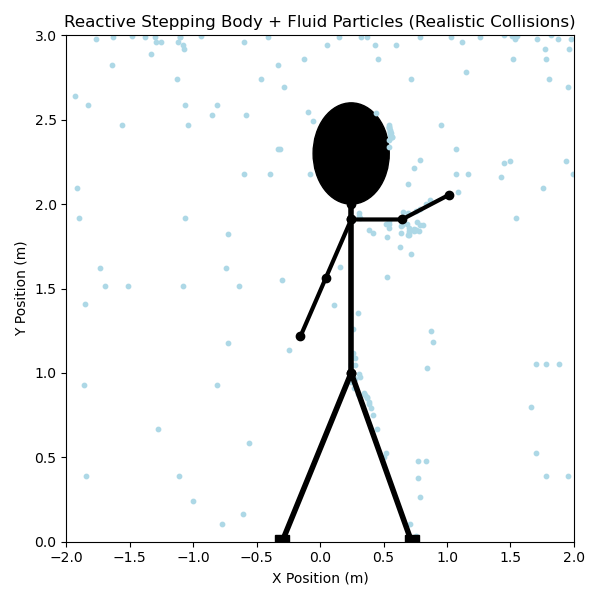

In [2]:
# main_simulation_visualization.ipynb
# Visualization and Animation Notebook
# CMSE 802 - Homework 3 Final Project
# Author: Gerardo Morales
# Date: April 2025

# -----------------------------------------------------------------------------
# NOTEBOOK CONFIGURATION
# -----------------------------------------------------------------------------

# For animation display inside Jupyter Notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sys
import os

# Add the path to the src folder to access project modules
sys.path.append(os.path.abspath("../src"))

# Import the main simulation function
from main_simulation import simulate_reactive_stepping_body

# -----------------------------------------------------------------------------
# RUN THE SIMULATION
# -----------------------------------------------------------------------------

# Execute the physics-based body + fluid simulation
results = simulate_reactive_stepping_body()

# Unpack simulation results
(time, torso_x, torso_y, foot_positions, com_positions, step_events,
 left_arm_joints, right_arm_joints, x_particles_trajectory, y_particles_trajectory) = results

# -----------------------------------------------------------------------------
# VISUALIZATION SETUP
# -----------------------------------------------------------------------------

# Create the figure and axis for animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2, 2)
ax.set_ylim(0, 3)
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_title("Reactive Stepping Body + Fluid Particles (Realistic Collisions)")

# Create plot elements for body parts
torso_line, = ax.plot([], [], 'o-', lw=4, color='black')  # Torso line
leg_line, = ax.plot([], [], 'o-', lw=4, color='black')    # Legs
left_arm_line, = ax.plot([], [], 'o-', lw=3, color='black')  # Left arm
right_arm_line, = ax.plot([], [], 'o-', lw=3, color='black')  # Right arm
head_circle = plt.Circle((0, 0), 0.3, color='black')  # Head as a circle
ax.add_patch(head_circle)

left_foot_marker, = ax.plot([], [], 's', color='black', markersize=10)   # Left foot
right_foot_marker, = ax.plot([], [], 's', color='black', markersize=10)  # Right foot

# Fluid particles (as scatter points)
scat = ax.scatter([], [], color='lightblue', s=10)

# -----------------------------------------------------------------------------
# INITIALIZE EMPTY PLOT ELEMENTS
# -----------------------------------------------------------------------------

def init():
    """Initialize all plot elements as empty for the animation."""
    torso_line.set_data([], [])
    leg_line.set_data([], [])
    left_arm_line.set_data([], [])
    right_arm_line.set_data([], [])
    left_foot_marker.set_data([], [])
    right_foot_marker.set_data([], [])
    head_circle.center = (0, 0)
    scat.set_offsets(np.empty((0, 2)))
    return (torso_line, leg_line, left_arm_line, right_arm_line,
            left_foot_marker, right_foot_marker, head_circle, scat)

# -----------------------------------------------------------------------------
# UPDATE FUNCTION PER FRAME
# -----------------------------------------------------------------------------

def update(frame):
    """Update the body, arms, and fluid particles at each time step."""
    
    # Foot positions
    lf_x, rf_x = foot_positions[frame]
    foot_y = 0

    # COM and torso positions
    com_x = com_positions[frame]
    tx = torso_x[frame]
    ty = torso_y[frame]

    # Legs setup
    knee_x = com_x
    knee_y = 1.0
    leg_x = [lf_x, knee_x, rf_x]
    leg_y = [foot_y, knee_y, foot_y]

    # Arms positions
    left_arm = left_arm_joints[frame]
    right_arm = right_arm_joints[frame]
    left_arm_x, left_arm_y = zip(*left_arm)
    right_arm_x, right_arm_y = zip(*right_arm)

    # Head position (attached to torso top)
    x_shoulder = tx
    y_shoulder = ty - 0.2
    x_head = x_shoulder
    y_head = y_shoulder + 0.3 + 0.2
    head_circle.center = (x_head, y_head)

    # Update fluid particle positions
    x_particles = x_particles_trajectory[frame]
    y_particles = y_particles_trajectory[frame]
    scat.set_offsets(np.c_[x_particles, y_particles])

    # Update body elements
    torso_line.set_data([com_x, tx], [foot_y + 1, ty])
    leg_line.set_data(leg_x, leg_y)
    left_arm_line.set_data(left_arm_x, left_arm_y)
    right_arm_line.set_data(right_arm_x, right_arm_y)
    left_foot_marker.set_data(lf_x, foot_y)
    right_foot_marker.set_data(rf_x, foot_y)

    return (torso_line, leg_line, left_arm_line, right_arm_line,
            left_foot_marker, right_foot_marker, head_circle, scat)

# -----------------------------------------------------------------------------
# RUN THE ANIMATION
# -----------------------------------------------------------------------------

ani = animation.FuncAnimation(
    fig, update, frames=len(time), init_func=init, blit=True, interval=20)

# -----------------------------------------------------------------------------
# EXPORT AS MP4 IF NEEDED
# -----------------------------------------------------------------------------

# Uncomment to save animation as video:
#ani.save("final_implementation.mp4", writer="ffmpeg", fps=60)

# Show animation
plt.tight_layout()
plt.show()
